# ADVANCED (20%)
### Pretrained RESNET-18 and RESNET-50

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# For loading popular data sets
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

from torch.utils.data.dataloader import DataLoader

#### Dataset Load and Transform

In [3]:
# Normalization
# Channel wise mean and standard deviation of the image

transform=transforms.Compose([transforms.RandomCrop(32, padding=4,padding_mode='reflect'), 
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomRotation(2.8),
                              transforms.RandomGrayscale(0.2),
                              transforms.ToTensor(),  # Convert images to Tensor ( Channel X Height X Width)
                              transforms.Normalize((0.4911, 0.4820, 0.4467),(0.2022, 0.1993, 0.2009)) 
                             ])

# Download training data
train = torchvision.datasets.CIFAR100(root='./data',train=True,download=True,transform=transform)


# Download test data                             
test = torchvision.datasets.CIFAR100(root='./data',train=False,download=True,transform=transform)



from torch.utils.data.dataloader import DataLoader
 
 # Define validation ratio 
validation_ratio= 0.2
batch_size = 32

# split training data in train and validation set
train_data,validation_data=torch.utils.data.random_split(train,[int((1-validation_ratio)*len(train)), 
                                              int((validation_ratio)*len(train))])

print(len(train_data))
print(len(validation_data))

train_loader = DataLoader(train_data, batch_size,pin_memory=True)
val_loader = DataLoader(validation_data, batch_size,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=1000,shuffle=False,pin_memory=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
40000
10000


In [4]:
# Check if your system has cuda gpu or only cpu

def check_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to transfer from CPU to GPU
def move_device(tensor, device):
    
    # Move all individual tensors from cpu to gpu
    if isinstance(tensor, (list,tuple)):
        return [move_device(element, device) for element in tensor]
    return tensor.to(device, non_blocking=True) 

# Execute transfer from CPU to GPU for each device
class DeviceDataLoader():
    
    # Define Constructor
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        
       # Transfer each batch and return
        for i in self.dl: 
            yield move_device(i, self.device)

    def __len__(self):
        
        # Return the number of batches
        return len(self.dl)


device = check_device()

# Move all the tensors to GPU
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [5]:
import torchvision.models as models

resnet_18 = models.resnet18(pretrained=True)
resnet_18 = resnet_18.cuda() if device else resnet_18
features_18 = resnet_18.fc.in_features
resnet_18.fc = nn.Linear(features_18, 100)
resnet_18.fc = resnet_18.fc.cuda() if device else resnet_18.fc

resnet_50=models.resnet50(pretrained=True)
resnet_50 = resnet_50.cuda() if device else resnet_50
features_50 = resnet_50.fc.in_features
resnet_50.fc = nn.Linear(features_50, 100)
resnet_50.fc = resnet_50.fc.cuda() if device else resnet_50.fc


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# ADVANCED (20%)
#### Testing with Resnet 18

In [22]:
model=resnet_18
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
%%time
def accuracy(predicted,labels):
    predictions, id=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(id==labels).item()/len(predicted))

# For validation
def evaluate(model,dl,loss_func):
    model.eval()
    loss_per_batch, accuracy_per_batch=[],[]
    for images,labels in valid_dl:
        #start loop
        with torch.no_grad():
            predicted=model(images)
        loss_per_batch.append(loss_func(predicted,labels))
        accuracy_per_batch.append(accuracy(predicted,labels))
    val_loss_epoch=torch.stack(loss_per_batch).mean().item()
    val_accuracy_epoch=torch.stack(accuracy_per_batch).mean().item()
    return val_loss_epoch,val_accuracy_epoch

def train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim):
    optimizer=optim(model.parameters(), max_lr, momentum=0.9,weight_decay=1e-5)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl))
    #scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5,verbose=True)
    #scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)
    
    results=[]
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        train_accuracy_per_batch=[]
        lrs=[]

        for images, labels in train_dl:
            predicted=model(images)
            loss=loss_func(predicted,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
          # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_accuracy_per_batch.append(accuracy(predicted,labels))
    
        scheduler.step()
        epoch_train_acc=torch.stack(train_accuracy_per_batch).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        val_loss_epoch,val_accuracy_epoch=evaluate(model,valid_dl,loss_func)
        
        results.append({'avg_valid_loss': val_loss_epoch,
                        'avg_val_acc': val_accuracy_epoch,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})
        
        print('Number of epochs:', epoch,'|', 
              'Validation loss :',val_loss_epoch, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',val_accuracy_epoch)
    return results


model=move_device(model,device)
epochs = 10

'''
Learning Rates
'''
max_lr2 = 1e-2
max_lr3 = 1e-3
max_lr4 = 1e-4

loss_func=nn.functional.cross_entropy

'''
Optimizers
'''
#optim=torch.optim.Adam
optim=torch.optim.SGD

'''
Train function call
'''
results2= train(model,train_dl,valid_dl,epochs, max_lr2, loss_func,optim)
results3= train(model,train_dl,valid_dl,epochs, max_lr3, loss_func,optim)
results4= train(model,train_dl,valid_dl,epochs, max_lr4, loss_func,optim)

Number of epochs: 0 | Validation loss : 2.4699254035949707  | Training loss : 3.197343587875366  |   Training accuracy: 0.2342749983072281 validation accuracy : 0.3608226776123047
Number of epochs: 1 | Validation loss : 2.2589735984802246  | Training loss : 2.4496846199035645  |   Training accuracy: 0.36844998598098755 validation accuracy : 0.4033546447753906
Number of epochs: 2 | Validation loss : 2.084754705429077  | Training loss : 2.183049440383911  |   Training accuracy: 0.42272499203681946 validation accuracy : 0.44369009137153625
Number of epochs: 3 | Validation loss : 2.042905569076538  | Training loss : 1.9954320192337036  |   Training accuracy: 0.4666000008583069 validation accuracy : 0.45656949281692505
Number of epochs: 4 | Validation loss : 1.9902265071868896  | Training loss : 1.8556722402572632  |   Training accuracy: 0.4988749921321869 validation accuracy : 0.4715455174446106
Number of epochs: 5 | Validation loss : 1.982299566268921  | Training loss : 1.742040991783142 

#### Visualization

In [28]:
'''
Training Accuracy
'''


avg_training_accuracy2=[]
for result in results2:
    avg_training_accuracy2.append(result['avg_train_acc'])
    
avg_training_accuracy3=[]
for result in results3:
    avg_training_accuracy3.append(result['avg_train_acc'])
    
avg_training_accuracy4=[]
for result in results4:
    avg_training_accuracy4.append(result['avg_train_acc'])
    

'''
Validation Accuracy
'''
avg_validation_accuracy2=[]
for result in results2:
    avg_validation_accuracy2.append(result['avg_val_acc'])
avg_validation_accuracy3=[]
for result in results3:
    avg_validation_accuracy3.append(result['avg_val_acc'])
avg_validation_accuracy4=[]
for result in results4:
    avg_validation_accuracy4.append(result['avg_val_acc'])

'''
Validation Loss
'''

    
avg_validation_loss2=[]
for result in results2:
    avg_validation_loss2.append(result['avg_valid_loss'])
    
avg_validation_loss3=[]
for result in results3:
    avg_validation_loss3.append(result['avg_valid_loss'])
    
avg_validation_loss4=[]
for result in results4:
    avg_validation_loss4.append(result['avg_valid_loss'])


'''
Training Loss
'''


avg_training_loss2=[]
for result in results2:
    avg_training_loss2.append(result['avg_train_loss'])
    
avg_training_loss3=[]
for result in results3:
    avg_training_loss3.append(result['avg_train_loss'])

avg_training_loss4=[]
for result in results4:
    avg_training_loss4.append(result['avg_train_loss'])

'''
Epochs count
'''
epoch_count=[]
for i in range(epochs):
    epoch_count.append(i)

### Validation loss

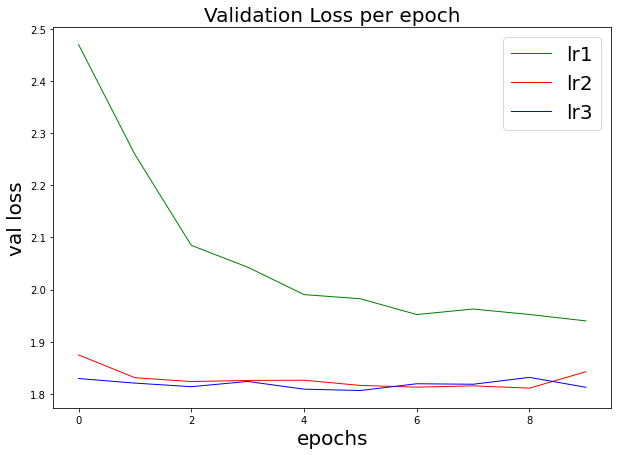

In [29]:
figure(figsize=(10,7))
plt.plot(epoch_count,avg_validation_loss2, 'green', label = "lr1", linewidth = '1')
plt.plot(epoch_count,avg_validation_loss3, 'red', label = "lr2", linewidth = '1')
plt.plot(epoch_count,avg_validation_loss4, 'blue', label = "lr3", linewidth = '1')
plt.title("Validation Loss per epoch",fontsize=20)
plt.xlabel("epochs",fontsize=20)  
plt.ylabel("val loss",fontsize=20)
plt.legend(fontsize=20)
plt.show()

### Training loss

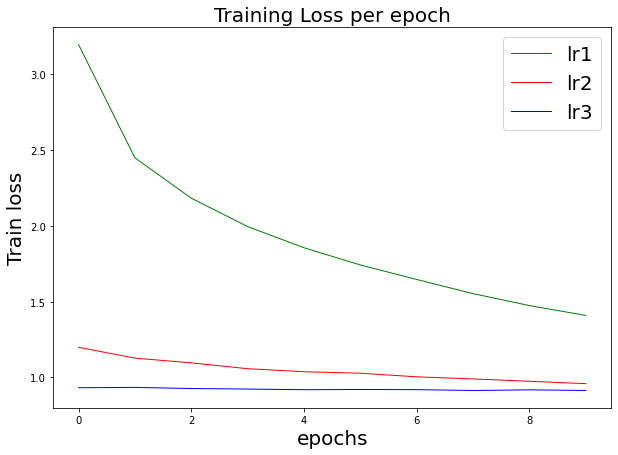

In [37]:
figure(figsize=(10,7))
plt.plot(epoch_count,avg_training_loss2, 'g', label = "lr1", linewidth = '1')
plt.plot(epoch_count,avg_training_loss3, 'r', label = "lr2", linewidth = '1')
plt.plot(epoch_count,avg_training_loss4, 'blue', label = "lr3", linewidth = '1')
plt.title("Training Loss per epoch",fontsize=20)
plt.xlabel("epochs",fontsize=20)  
plt.ylabel("Train loss",fontsize=20)

plt.legend(fontsize=20)
plt.show()

#### Training and Validation Accuracy

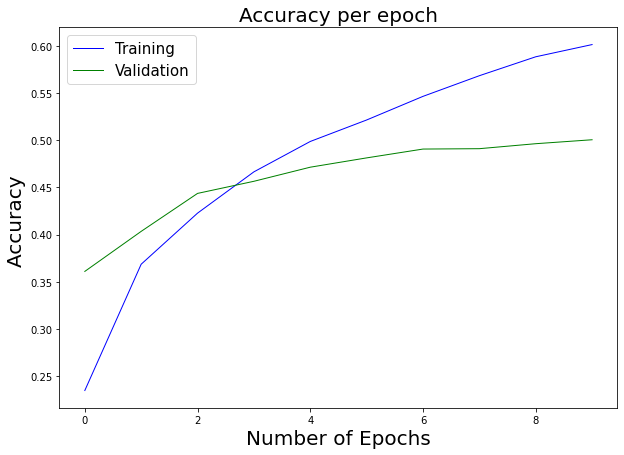

In [35]:
figure(figsize=(10,7))
plt.plot(epoch_count,avg_training_accuracy2, 'b-', label = "Training", linewidth = '1')
plt.plot(epoch_count,avg_validation_accuracy2, 'g-', label = "Validation", linewidth = '1')
plt.title("Accuracy per epoch",fontsize=20)
plt.xlabel("Number of Epochs",fontsize=20)  
plt.ylabel("Accuracy ",fontsize=20)
plt.legend(fontsize=15)
plt.show()

#### Testing Accuracy

In [38]:
%%time
# train on that particular learning rate
def accuracy(predicted,labels):
    predictions, id=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(id==labels).item()/len(predicted))

# For validation
def evaluate(model,dl,loss_func):
    model.eval()
    loss_per_batch, accuracy_per_batch=[],[]
    for images,labels in valid_dl:
        #start loop
        with torch.no_grad():
            predicted=model(images)
        loss_per_batch.append(loss_func(predicted,labels))
        accuracy_per_batch.append(accuracy(predicted,labels))
    val_loss_epoch=torch.stack(loss_per_batch).mean().item()
    val_accuracy_epoch=torch.stack(accuracy_per_batch).mean().item()
    return val_loss_epoch,val_accuracy_epoch

def train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim):
    optimizer=optim(model.parameters(), max_lr, momentum=0.9,weight_decay=1e-5)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl))
    #scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5,verbose=True)
    #scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)
    
    results=[]
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        train_accuracy_per_batch=[]
        lrs=[]

        for images, labels in train_dl:
            predicted=model(images)
            loss=loss_func(predicted,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
          # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_accuracy_per_batch.append(accuracy(predicted,labels))
    
        scheduler.step()
        epoch_train_acc=torch.stack(train_accuracy_per_batch).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        val_loss_epoch,val_accuracy_epoch=evaluate(model,valid_dl,loss_func)
        
        results.append({'avg_valid_loss': val_loss_epoch,
                        'avg_val_acc': val_accuracy_epoch,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})
        
        print('Number of epochs:', epoch,'|', 
              'Validation loss :',val_loss_epoch, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',val_accuracy_epoch)
    return results


model=move_device(model,device)
epochs = 10

'''
Learning Rates
'''
max_lr2 = 1e-2

loss_func=nn.functional.cross_entropy

'''
Optimizers
'''
#optim=torch.optim.Adam
optim=torch.optim.SGD

'''
Train function call
'''
results= train(model,train_dl,valid_dl,epochs, max_lr2, loss_func,optim)



# Test
_,test_acc=evaluate(model, test_dl, loss_func)
print(test_acc)


Number of epochs: 0 | Validation loss : 2.0258710384368896  | Training loss : 1.1428731679916382  |   Training accuracy: 0.6736000180244446 validation accuracy : 0.5015974640846252
Number of epochs: 1 | Validation loss : 2.0347113609313965  | Training loss : 1.087228775024414  |   Training accuracy: 0.6884250044822693 validation accuracy : 0.5
Number of epochs: 2 | Validation loss : 2.0311617851257324  | Training loss : 1.0542583465576172  |   Training accuracy: 0.6973749995231628 validation accuracy : 0.5024960041046143
Number of epochs: 3 | Validation loss : 2.0545201301574707  | Training loss : 1.0059000253677368  |   Training accuracy: 0.7067000269889832 validation accuracy : 0.5019968152046204
Number of epochs: 4 | Validation loss : 2.0406408309936523  | Training loss : 0.9538673758506775  |   Training accuracy: 0.7246249914169312 validation accuracy : 0.5101836919784546
Number of epochs: 5 | Validation loss : 2.1461501121520996  | Training loss : 0.9071981906890869  |   Training 

### Test Accuracy for ResNet 18

In [39]:
# Test
_,test_acc=evaluate(model, test_dl, loss_func)
print('Test Accuracy is : ',test_acc)


Test Accuracy is :  0.5038937926292419


# ADVANCED (20%)
## ResNet 50

In [6]:
model=resnet_50
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training

In [9]:
%%time
# train on that particular learning rate
def accuracy(predicted,labels):
    predictions, id=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(id==labels).item()/len(predicted))

# For validation
def evaluate(model,dl,loss_func):
    model.eval()
    loss_per_batch, accuracy_per_batch=[],[]
    for images,labels in valid_dl:
        #start loop
        with torch.no_grad():
            predicted=model(images)
        loss_per_batch.append(loss_func(predicted,labels))
        accuracy_per_batch.append(accuracy(predicted,labels))
    val_loss_epoch=torch.stack(loss_per_batch).mean().item()
    val_accuracy_epoch=torch.stack(accuracy_per_batch).mean().item()
    return val_loss_epoch,val_accuracy_epoch

def train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim):
    optimizer=optim(model.parameters(), max_lr, momentum=0.9,weight_decay=1e-5)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl))
    #scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5,verbose=True)
    #scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)
    
    results=[]
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        train_accuracy_per_batch=[]
        lrs=[]

        for images, labels in train_dl:
            predicted=model(images)
            loss=loss_func(predicted,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
          # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_accuracy_per_batch.append(accuracy(predicted,labels))
    
        scheduler.step()
        epoch_train_acc=torch.stack(train_accuracy_per_batch).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        val_loss_epoch,val_accuracy_epoch=evaluate(model,valid_dl,loss_func)
        
        results.append({'avg_valid_loss': val_loss_epoch,
                        'avg_val_acc': val_accuracy_epoch,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})
        
        print('Number of epochs:', epoch,'|', 
              'Validation loss :',val_loss_epoch, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',val_accuracy_epoch)
    return results


model=move_device(model,device)
epochs = 15

'''
Learning Rates
'''
max_lr2 = 1e-2

loss_func=nn.functional.cross_entropy

'''
Optimizers
'''
#optim=torch.optim.Adam
optim=torch.optim.SGD

'''
Train function call
'''
results= train(model,train_dl,valid_dl,epochs, max_lr2, loss_func,optim)

Number of epochs: 0 | Validation loss : 2.354605197906494  | Training loss : 3.080040216445923  |   Training accuracy: 0.2551000118255615 validation accuracy : 0.3850838541984558
Number of epochs: 1 | Validation loss : 2.06229567527771  | Training loss : 2.237826108932495  |   Training accuracy: 0.4109250009059906 validation accuracy : 0.4536741077899933
Number of epochs: 2 | Validation loss : 1.9198222160339355  | Training loss : 1.9390640258789062  |   Training accuracy: 0.4768249988555908 validation accuracy : 0.4862220585346222
Number of epochs: 3 | Validation loss : 1.8678064346313477  | Training loss : 1.7458786964416504  |   Training accuracy: 0.5234249830245972 validation accuracy : 0.5043929815292358
Number of epochs: 4 | Validation loss : 1.8022511005401611  | Training loss : 1.5986768007278442  |   Training accuracy: 0.5595499873161316 validation accuracy : 0.517372190952301
Number of epochs: 5 | Validation loss : 1.788769245147705  | Training loss : 1.4686111211776733  |   

### Visualizations

In [11]:
'''
Training Accuracy
'''
avg_training_accuracy=[]
for result in results:
    avg_training_accuracy.append(result['avg_train_acc'])
    

'''
Validation Accuracy
'''
avg_validation_accuracy=[]
for result in results:
    avg_validation_accuracy.append(result['avg_val_acc'])

'''
Validation Loss
''' 
avg_validation_loss=[]
for result in results:
    avg_validation_loss.append(result['avg_valid_loss'])
    


'''
Training Loss
'''
avg_training_loss=[]
for result in results:
    avg_training_loss.append(result['avg_train_loss'])
    
'''
Epochs count
'''
epoch_count=[]
for i in range(epochs):
    epoch_count.append(i)

#### Training and Validation Loss

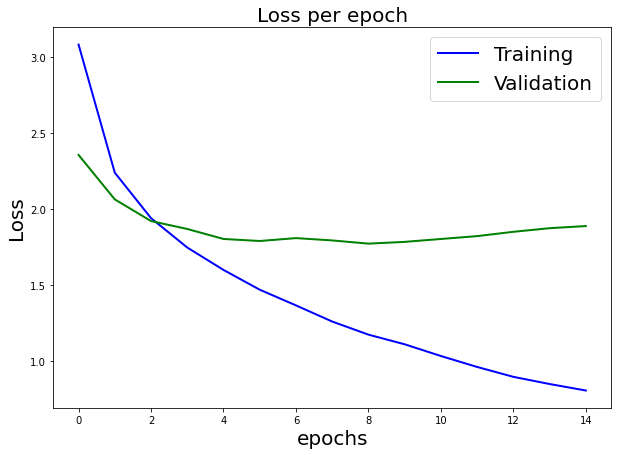

In [15]:
figure(figsize=(10,7))
plt.plot(epoch_count,avg_training_loss, 'b-',label = "Training", linewidth = '2')
plt.plot(epoch_count,avg_validation_loss, 'g-', label = "Validation", linewidth = '2')
plt.title("Loss per epoch",fontsize=20)
plt.xlabel("epochs",fontsize=20)  
plt.ylabel("Loss",fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Training and Validation Accuracy

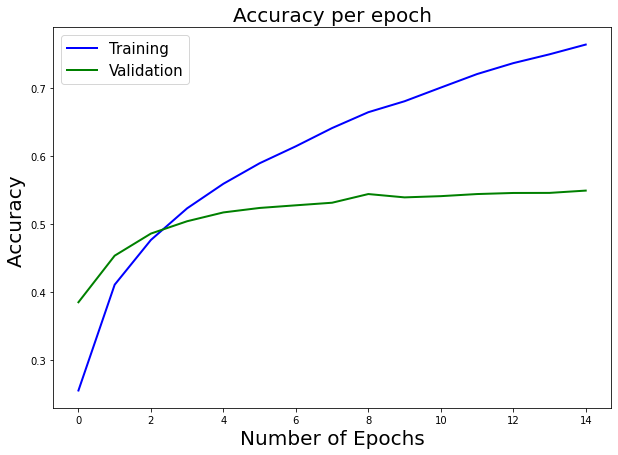

In [16]:
figure(figsize=(10,7))
plt.plot(epoch_count,avg_training_accuracy, 'b-', label = "Training", linewidth = '2')
plt.plot(epoch_count,avg_validation_accuracy, 'g-', label = "Validation", linewidth = '2')
plt.title("Accuracy per epoch",fontsize=20)
plt.xlabel("Number of Epochs",fontsize=20)  
plt.ylabel("Accuracy ",fontsize=20)
plt.legend(fontsize=15)
plt.show()

### Test Accuracy for ResNet 50

In [14]:
# Test
_,test_acc=evaluate(model, test_dl, loss_func)
print('Test Accuracy for ResNet 50 is : ',test_acc)

Test Accuracy for ResNet 50 is :  0.547723650932312
